# Building Damage from Floods

## Economic Flood Risk Methodology

Flood risk in the form of economic damage at a building level is computed from flood depth maps and building data.  The damages are computed for each supplied flood event return period and then integrated over all of the event return periods to determine expected annual damage (EAD). Damage to each building varies based on the depth water, reconstruction costs, value of its contents, and its footprint area.

- River flood extent and water depth are from the [Copernicus Land Monitoring Service](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different event return periods at a 100m grid spacing.
- Building data including type and footprint are obtained from [OpenStreetMap](https://www.openstreetmap.org/copyright).
- Building damage fraction, reconstruction costs, and the value of its contents are determined using the [JRC methodology](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688).

The code can be customized to use any flood depth hazard, building data, and depth-damage relationships.

### Import Modules

These modules are needed to process the flood depth raster data and building shapefiles as well as plot the results.
- [os](https://docs.python.org/3/library/os.html): For interacting with the operating system, allowing the creation of directories and file manipulation.
- [sys](https://docs.python.org/3/library/sys.html): Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- [numpy](https://numpy.org/): A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/): A data manipulation and analysis library, essential for working with structured data in tabular form.
- [geopandas](https://geopandas.org): Extends the datatypes used by pandas to allow spatial operations on geometric types.
- [rasterio](https://rasterio.readthedocs.io/en/stable/): For reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rasterstats](https://pythonhosted.org/rasterstats): For summarizing geospatial raster datasets based on vector geometries.
- [shapely](https://pypi.org/project/shapely/): For manipulation and analysis of planar geometric objects.
- [osgeo](https://www.osgeo.org/): For translating raster and vector geospatial data formats.
- [osmnx](https://osmnx.readthedocs.io/) To easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap.
- [pyproj](https://pyproj4.github.io/pyproj/dev/index.html): Interface for PROJ (cartographic projections and coordinate transformations library).
- [matplotlib](https://matplotlib.org/): Used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/): For adding basemaps to plots, enhancing geospatial visualizations.
- [urllib.request](https://docs.python.org/3/library/urllib.request.html): Defines functions and classes which help in opening URLs (mostly HTTP) in a complex world — basic and digest authentication, redirections, cookies and more.
- [zipfile](https://docs.python.org/3/library/zipfile.html): Provides tools to create, read, write, append, and list a ZIP file.
- [sockect](https://docs.python.org/3/library/socket.html): pPovides access to the BSD socket interface.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
import rasterstats
from osgeo import gdal, osr
from shapely.geometry import box, Polygon
import osmnx as ox
from pyproj import Transformer
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import contextily as ctx
import urllib.request
import zipfile
import socket

## Definitions

- Bounds of area of interest.  Positive values denote north and east, and negative values denote south and west.
- Return periods
- Directory locations
- Colorbars for maps

In [2]:

# Florence, Italy
# Latitude1, Latitude2 = 43.76, 43.79
# Longitude1, Longitude2 = 11.24, 11.30

# Žilina, Slovakia
Latitude1, Latitude2 = 49.2, 49.25
Longitude1, Longitude2 = 18.67, 18.8

# Return Periods of Interest
ReturnPeriods = [10, 20, 50, 100, 200, 500]  # Return period levels

# Directory of main folder (working directory)
dirWork = '.'
os.chdir(dirWork)

# Input Hazard Path
dirDepths = os.path.join(dirWork, 'data')
if not os.path.exists(dirDepths):
    os.makedirs(dirDepths)

# OSM Output Path
dirOSM = os.path.join(dirWork, 'OSM')
if not os.path.exists(dirOSM):
    os.makedirs(dirOSM)

# Results directory
dirResults = os.path.join(dirWork, 'DamageBuildings')
if not os.path.exists(dirResults):
    os.makedirs(dirResults)

# Water Depth Colorbar for Maps
cmap_h2o = LinearSegmentedColormap.from_list('gist_stern_inv',
                                             ['lightblue', 'blue', 'red'], N=256)
# Building Class Colorbar for Maps
cmap_cls = LinearSegmentedColormap.from_list('gist_stern_inv',
                                             ['purple', 'blue', 'red'], N=256)

## Download Data

- Download flood depth rasters to the data folder if the file doesn't exist.
- River flood extent and water depth are from the [Copernicus Land Monitoring Service](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different event return periods at a 100m grid spacing.

In [3]:
urlData = 'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/FLOODS/EuropeanMaps/'
timeout = 60     # Download time out in seconds
max_retries = 5  # Maximum number of download attempts

socket.setdefaulttimeout(timeout)

for RP in ReturnPeriods:

    print(f'Return Period={str(RP)}')
    strRP = f'{RP:03d}'
    dirRP = f'floodMap_RP{strRP}'
    rastDepths = os.path.join(dirDepths, f'floodmap_EFAS_RP{strRP}_C.tif')
    if os.path.exists(rastDepths):
        print(f'Flood depth raster already exists (skipping download): {rastDepths}')
    else:
        rastZip = f'floodMap_RP{strRP}.zip'
        pathRastZip = os.path.join(dirDepths, rastZip)
        urlRastZip = os.path.join(urlData, rastZip)
        print(urlRastZip)
        for attempt in range(1, max_retries + 1):
            print(f'    Attempt: {attempt}')
            try:
                urllib.request.urlretrieve(urlRastZip, pathRastZip)
                break  # Break loop if download is successful
            except Exception as e:
                print('      Timeout.  Retry data download')
                if attempt == max_retries:
                    print('    Maximum number of timeouts reached.  Data download failed')
                    print(f'      Consider increasing timeout value {timeout} seconds')
                    print(f'      Consider increasing maximum number of download attempts {max_retries}')
                    raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}')
        print('  Unzipping downloaded file')
        with ZipFile(pathRastZip, 'r') as zip_ref:
            zip_ref.extractall(dirDepths)

Return Period=10
Flood depth raster already exists (skipping download): ./data/floodmap_EFAS_RP010_C.tif
Return Period=20
Flood depth raster already exists (skipping download): ./data/floodmap_EFAS_RP020_C.tif
Return Period=50
Flood depth raster already exists (skipping download): ./data/floodmap_EFAS_RP050_C.tif
Return Period=100
Flood depth raster already exists (skipping download): ./data/floodmap_EFAS_RP100_C.tif
Return Period=200
Flood depth raster already exists (skipping download): ./data/floodmap_EFAS_RP200_C.tif
Return Period=500
Flood depth raster already exists (skipping download): ./data/floodmap_EFAS_RP500_C.tif


## Define Depth-Damage Functions

Maximum Damage Values
- Huizinga, J., Moel, H. de, Szewczyk, W. (2017). Global flood depth-damage functions. Methodology and the database with guidelines. EUR 28552 EN. doi: 10.2760/16510)
- First array value is 2010 building reconstruction costs per square meter
- Second value is 2010 building content replacement value per square meter
- CPI2010 = 2010 [World Bank Consumer Price Index](https://data.worldbank.org/indicator/FP.CPI.TOTL) for country of interest
- CPI2022 = 2022 Consumer Price Index for country of interest (latest value)

Damage Classes
- Options are Residential, Commercial, Industrial, Agriculture, Cultural, and Transportation.
- In the default code, Agriculture, Cultural, and Transportation as well as unclassified buildings are set to commercial

Damage Function
- Based on polynomial functions fit to the JRC depth-damage curves, with the order depending on fit (coefs).
- In the default code, a combined damage function is applied based on Residential, Commercial, and Industrial JRC depth-damage values
- Huizinga, J., Moel, H. de, Szewczyk, W. (2017). Global flood depth-damage functions. Methodology and the database with guidelines. EUR 28552 EN. doi: 10.2760/16510

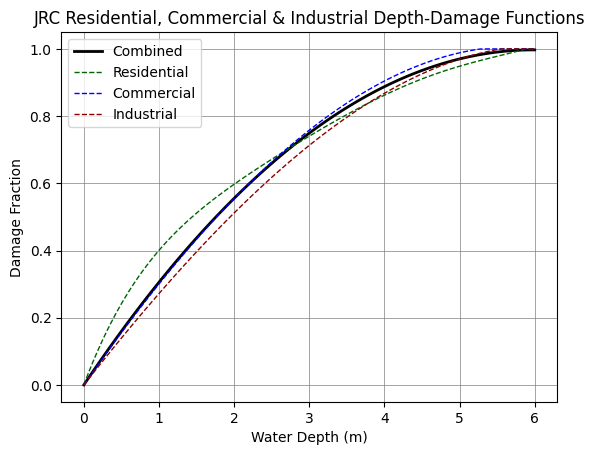

In [4]:
# Define arrays for damage values based on 2010 estimates
CPI2010 = 100                                  # 2010 EU Value
CPI2022 = 121.8                                # 2022 EU Value
CPI_Frac = CPI2022 / CPI2010
MaxDmgRES = np.array([480, 240]) * CPI_Frac    # EU Value
MaxDmgCOM = np.array([502, 502]) * CPI_Frac    # EU Value
MaxDmgIND = np.array([328, 492]) * CPI_Frac    # EU Value
MaxDmgAGR = np.array([0.23, 0.46]) * CPI_Frac  # Italy 2021 (AGR), 0.23 EUR/m2
MaxDmgCUL = MaxDmgCOM                          # EU Value
MaxDmgTRS = MaxDmgIND                          # Italy 2021 (TRS)
# Combine damage arrays into a single array
MaxDmg = np.column_stack((MaxDmgRES, MaxDmgCOM, MaxDmgIND))

# Compute damages based on Mean, Maximum, and/or Minimum depths
#   Options are ['Mean', 'Maximum', 'Minimum']
Depths = ['Mean']

# Damage classes
DamageClasses = ['Residential', 'Commercial', 'Industrial']

def DamageFunction(wd1, coefs, wd_range=(0, 6)):
    """
    Calculate damage based on polynomial functions.

    Parameters:
    - wd1 (float): Water depth.
    - coefs (list): Coefficients of the polynomial function.
    - wd_range (tuple): Range for water depth. Default is (0, 6).

    Returns:
    float: Calculated damage.
    """
    wd = np.clip(wd1, *wd_range)
    y = coefs[0] * wd**5 + coefs[1] * wd**4 + coefs[2] * wd**3 \
        + coefs[3] * wd**2 + coefs[4] * wd + coefs[5]
    y = np.clip(y, 0, 1)
    return y

# Polynomial coefficients for each function
#   - Up to 5th order
#   - 1st value is highest order (5th) and last is intercept
coefs_GEN = [0.0,  0.0, 0.0, -0.02787, 0.3334, 0.0]
coefs_RES = [0.0005869, -0.01077, 0.07497, -0.2602, 0.5959, 0.0]
coefs_COM = [0.0, 0.0, -0.0009149, -0.02021, 0.3216, 0.0]
coefs_IND = [0.0, 0.0, -0.001202, -0.01225, 0.2852, 0.0]
coefs_TRS = [0.0, -0.00938, 0.07734, -0.2906, 0.7625, 0.0]
coefs_AGR = [0.0, -0.004601, 0.06114, -0.3061, 0.7773, 0.0]

# Plot Depth Damage Functions
# Water depth values from 0 to 6m
wd_values = np.linspace(0, 6, 100)
dmgRES = DamageFunction(wd_values, coefs_RES)
dmgCOM = DamageFunction(wd_values, coefs_COM)
dmgIND = DamageFunction(wd_values, coefs_IND)
dmgGEN = DamageFunction(wd_values, coefs_GEN)

plt.plot(wd_values, dmgGEN, color='black', linewidth=2, label='Combined')
plt.plot(wd_values, dmgRES, color='darkgreen', linestyle='--', linewidth=1,
         label='Residential')
plt.plot(wd_values, dmgCOM, color='blue', linestyle='--', linewidth=1,
         label='Commercial')
plt.plot(wd_values, dmgIND, color='darkred', linestyle='--', linewidth=1,
         label='Industrial')
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.xlabel('Water Depth (m)')
plt.ylabel('Damage Fraction')
plt.title('JRC Residential, Commercial & Industrial Depth-Damage Functions')
plt.legend()
plt.show()

### Bounding Box Computations
- Converts latitude and longitude values to the evuivalent projection used by the water depth raster Projection, bounds of zoom raster & write bounding box to shapefile
- Defines bounding box for OpenStreetMap data.

Here the selected bounding box of the data can be checked by looking at the generated map.  If the region of interest is not as desired, the latitude and longitude values can be changed above.

Raster Projection EPSG: 3035
Converted Coordinate Bounds
  Longitudes: 18.67E --> 4951330.508515647 meters & 18.8E --> 4960078.221695254 meters
  Latitudes: 49.2N --> 2935745.210331803 meters & 49.25N --> 2942395.0867714845 meters
Bounding Box Shapefile written to: ./OSM/bbox.shp
  49.2N to 49.25N
  18.67E to 18.8E


/opt/homebrew/anaconda3/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


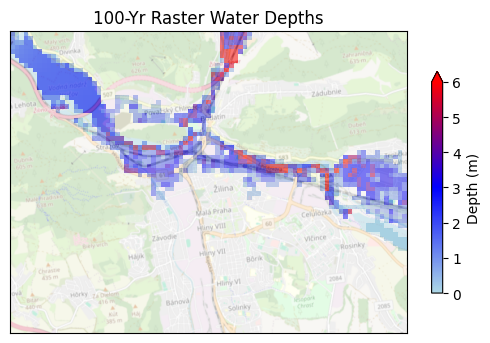

Adjust latitude and longitude bounds as needed
  49.2N to 49.25N
  18.67E to 18.8E


In [5]:
# Open first RP raster
strRP = f'{100:03d}'
rastDepths = 'floodmap_EFAS_RP' + strRP + '_C.tif'
rastDepths = os.path.join(dirDepths, rastDepths)
shpBBox = os.path.join(dirOSM, 'bbox.shp')

# Determine Raster EPSG Code (only works with osgeo)
ds = gdal.Open(rastDepths)
srs = osr.SpatialReference()
srs.ImportFromWkt(ds.GetProjection())
epsgRast = srs.GetAuthorityCode(None)
ds = None

print(f'Raster Projection EPSG: {epsgRast}')

# Create a transformer for coordinate conversion
transformer = Transformer.from_crs('EPSG:4326', f'EPSG:{epsgRast}', always_xy=True)

# Convert bounding box coordinates to raster CRS
xMin, yMin = transformer.transform(Longitude1, Latitude1)
xMax, yMax = transformer.transform(Longitude2, Latitude2)

# Ensure xMin < xMax and yMin < yMax
xMin, xMax = min(xMin, xMax), max(xMin, xMax)
yMin, yMax = min(yMin, yMax), max(yMin, yMax)

print('Converted Coordinate Bounds')
print(f'  Longitudes: {Longitude1}E --> {xMin} meters & {Longitude2}E --> {xMax} meters')
print(f'  Latitudes: {Latitude1}N --> {yMin} meters & {Latitude2}N --> {yMax} meters')

# Define the bounding box coordinates based on the zoomed region
bboxRast = box(xMin, yMin, xMax, yMax)
bounding_box = gpd.GeoDataFrame(geometry=[bboxRast], crs=epsgRast)

# Write the GeoDataFrame to a shapefile
bounding_box.to_file(shpBBox)
print('Bounding Box Shapefile written to: '+shpBBox)

# Read the raster using rasterio
with rasterio.open(rastDepths) as src:
    window = from_bounds(xMin, yMin, xMax, yMax, src.transform)
    rDepths = src.read(1, window=window)
    rDepths = np.ma.masked_where((rDepths < -999) | (rDepths > 1000), rDepths)
    missing_data_value = src.nodata

# Read GeoDataFrame from the bounding box shapefile
gdfBBox = gpd.read_file(shpBBox)
crsRast = gdfBBox.crs
bboxRast = gdfBBox.total_bounds

# Adjust bounding box coordinates for OSM data
bboxOSM = bboxRast
bboxOSM[1] = Latitude1
bboxOSM[3] = Latitude2
bboxOSM[0] = Longitude1
bboxOSM[2] = Longitude2

# Create a GeoSeries representing the bounding box polygon
bboxOSM_poly = gpd.GeoSeries(
    [Polygon([(bboxOSM[0], bboxOSM[1]), (bboxOSM[2], bboxOSM[1]),
              (bboxOSM[2], bboxOSM[3]), (bboxOSM[0], bboxOSM[3])])],
    crs=crsRast
)
bboxOSM_poly = bboxOSM_poly.to_crs(crsRast)

print(f'  {str(Latitude1)}N to {str(Latitude2)}N')
print(f'  {str(Longitude1)}E to {str(Longitude2)}E')
# Check select bounding latitude-longitude box
fig, ax = plt.subplots()
im = ax.imshow(rDepths, vmin=0, vmax=6, cmap=cmap_h2o, extent=(xMin, xMax, yMin, yMax))
cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', label='Depth (m)', shrink=0.6)
ctx.add_basemap(ax, crs=f'EPSG:{epsgRast}', source=ctx.providers.OpenStreetMap.Mapnik,
                attribution='', alpha=0.5)
ax.set_xticks([]), ax.set_yticks([])
plt.title(f'{strRP}-Yr Raster Water Depths')
plt.show()

print('Adjust latitude and longitude bounds as needed')
print(f'  {str(Latitude1)}N to {str(Latitude2)}N')
print(f'  {str(Longitude1)}E to {str(Longitude2)}E')

### OpenStreetMap Building Data

Here the OSM data are loaded based on the bounding box defined above.  The extracted data represent the building use (unclassified) are written to a shapefile.

/var/folders/vy/szcnx44s3cjd79_sxq530zf80000gp/T/ipykernel_47343/2153947895.py:7: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdfOSM = ox.geometries_from_polygon(bboxOSM_poly.iloc[0], tags)
/var/folders/vy/szcnx44s3cjd79_sxq530zf80000gp/T/ipykernel_47343/2153947895.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gdfOSM = gdfOSM.applymap(lambda x: str(x) if isinstance(x, list) else x)
/var/folders/vy/szcnx44s3cjd79_sxq530zf80000gp/T/ipykernel_47343/2153947895.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfOSM.to_file(shpOSM, driver='ESRI Shapefile')


OSM data read in and saved to shapefile
  ./OSM/OSM_Building_Unclassified.shp


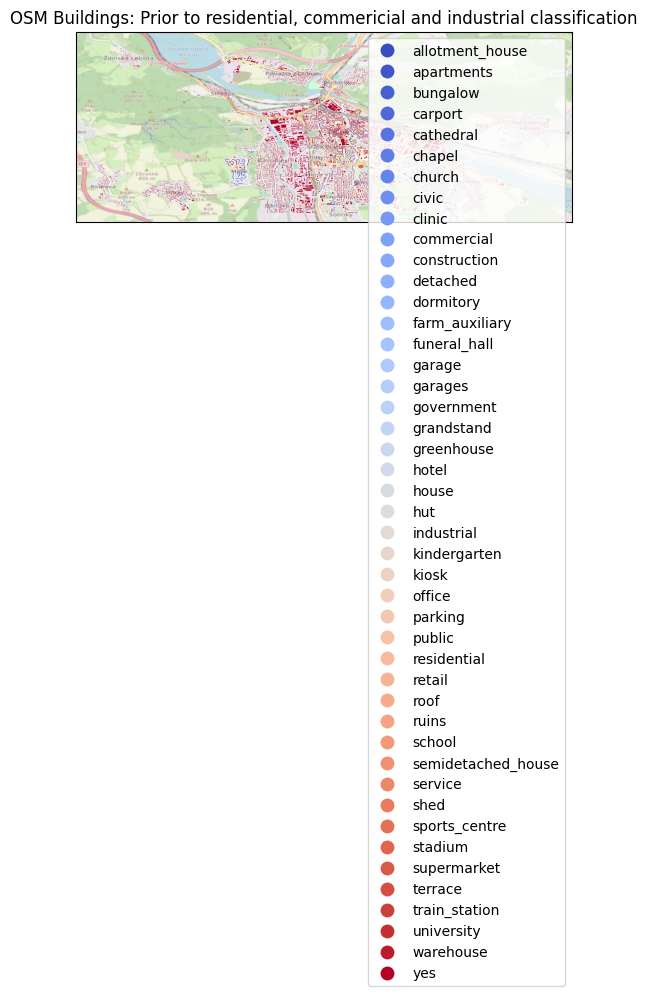

In [6]:
# Output shapefile for unclassified buildings
shpOSM = os.path.join(dirOSM, 'OSM_Building_Unclassified.shp')

# Define tags for OSM data
tags = {'building': True}
# Retrieve OSM geometries within the bounding box
gdfOSM = ox.geometries_from_polygon(bboxOSM_poly.iloc[0], tags)
# Filter out non-Polygon geometries
gdfOSM = gdfOSM[gdfOSM.geom_type == 'Polygon']
# Confirm that all of the GDF elements are compatible with shp format
gdfOSM = gdfOSM.applymap(lambda x: str(x) if isinstance(x, list) else x)
# Clip the OSM data to the bounding box
gdfOSM = gpd.clip(gdfOSM, bboxOSM)
# Save the polygon-only gdp to shapefile
gdfOSM.to_file(shpOSM, driver='ESRI Shapefile')
print('OSM data read in and saved to shapefile')

print('  '+shpOSM)

# Plot data
ax = gdfOSM.plot(column='building', legend=True, cmap='coolwarm')
ctx.add_basemap(ax, crs=gdfOSM.crs, source=ctx.providers.OpenStreetMap.Mapnik,
                attribution='', alpha=0.8)
ax.set_xticks([]), ax.set_yticks([])
plt.title('OSM Buildings: Prior to residential, commericial and industrial classification')
plt.show()

### Reproject OSM data to raster projection

In order to perform the damage analysis, the OSM and raster data need to be on the same Coordinate Reference System (CRS). The OSM are on an EPSG:4326 CRS and the raster data could be another.  In the cell, the OSM data are converted to match the raster CRS.

In [7]:
# Determine CRSs from shapefile and Raster
crsOSM = gdfOSM.crs

if crsOSM not in (f'EPSG:{epsgRast}', f'epsg:{epsgRast}'):

    print(f'Reprojecting from OSM {crsOSM} to raster EPSG:{epsgRast}')

    # Read the GeoDataFrame if reprojection is needed
    gdfOSM = gpd.read_file(shpOSM)
    # Reproject the GeoDataFrame to match the raster CRS
    gdfOSM = gdfOSM.to_crs(epsg=epsgRast)
    # Save the reprojected data back to the shapefile
    gdfOSM.to_file(shpOSM)
    print('  Overwriting reprojected data:', shpOSM)

else:

    print('No reprojection performed. Both projections are the same:', crsOSM)

print('Done')

Reprojecting from OSM epsg:4326 to raster EPSG:3035
  Overwriting reprojected data: ./OSM/OSM_Building_Unclassified.shp
Done


### Building classifications
In this cell, the building types are classified to Residential, Commercial, Industrial, etc.
- This procedure needs to be performed manually by looking at the outputed list.
- If None is listed for a building class (bldgClass column), the building type (building column) should be assigned to one of the lists (e.g., classResidential, classCommercial, classIndustrial).
- Buildings with type "yes" will be classified as Commercial by default in a later step.

In [8]:
# CSV file with classifications (classResidential, classCommercial, etc)
csvOSMclasses = os.path.join(dirOSM, 'OSM_Building_Reclassified.csv')

 # Keep only the building and geometry columns
gdfBuildings = gdfOSM[['building','geometry']].copy()

# Building classifications
#   - Change and add as needed
classResidential = ['hut', 'apartments', 'detached', 'residential', 'house', 'barn', 'garage',
                    'carport', 'semidetached_house', 'shed', 'bungalow', 'roof', 'terrace',
                    'allotment_house']
classCommercial = ['commercial', 'office', 'retail', 'kiosk', 'supermarket', 'warehouse',
                   'garages', 'hotel', 'stadium', 'grandstand', 'sports_centre',  'pavilion',
                   'government', 'school', 'kindergarten', 'university', 'dormitory', 'public',
                   'service', 'hospital', 'clinic', 'civic', 'terminal', 'fire_station',
                   'train_station', 'boathouse', 'toilets', 'tech_cab', 'tower', 'portal',
                   'columbarium', 'cloister', 'greenhouse', 'guardhouse', 'construction',
                   'funeral_hall']
classIndustrial = ['industrial', 'manufacture']
classCultural = ['church', 'cathedral', 'baptistery', 'obelisk', 'basilica', 'monastery', 'ruins',
                 'column', 'chapel', 'synagogue', 'shrine', 'religious', 'convent', 'fort']
classAgricultural = ['farm_auxiliary']
classTransportation = ['bridge', 'parking']

# For now, set transportation and cultural to commercial (can add/change if desired)
classCommercial = classCommercial + classCultural + classAgricultural + classTransportation
classCultural = []
classAgricultural = []
classTransportation = []

# Convert building classes to dataframe
bldgClasses = pd.DataFrame({'building': gdfBuildings['building'].unique()})

# Classify each structure to Residential, Commercial, Industrial, etc.
#   - Structures not listed in above class lists are classified as none
bldgClasses['bldgClass'] = None
bldgClasses.loc[bldgClasses['building'].isin(classResidential), 'bldgClass'] = 'Residential'
bldgClasses.loc[bldgClasses['building'].isin(classCommercial), 'bldgClass'] = 'Commercial'
bldgClasses.loc[bldgClasses['building'].isin(classIndustrial), 'bldgClass'] = 'Industrial'
bldgClasses.loc[bldgClasses['building'].isin(classCultural), 'bldgClass'] = 'Cultural'
bldgClasses.loc[bldgClasses['building'].isin(classAgricultural), 'bldgClass'] = 'Agricultural'
bldgClasses.loc[bldgClasses['building'].isin(classTransportation), 'bldgClass'] = 'Transportation'

# Write structure and classification to CSV
bldgClasses.to_csv(csvOSMclasses, index=False)

print('Building Classifications')
print('  - If None is listed for a building class, add the building one of the above lists.')
print('  - Building yes will be classified as Commercial in a later step.')
print(bldgClasses)
print('Add buildings to classes and change classes as needed')
print('  - Building "yes" will be classified as Commercial by default in a later step.')

Building Classifications
  - If None is listed for a building class, add the building one of the above lists.
  - Building yes will be classified as Commercial in a later step.
              building    bldgClass
0           industrial   Industrial
1           commercial   Commercial
2                  yes         None
3            warehouse   Commercial
4               retail   Commercial
5           university   Commercial
6           apartments  Residential
7              service   Commercial
8                house  Residential
9   semidetached_house  Residential
10              garage  Residential
11              school   Commercial
12             terrace  Residential
13             garages   Commercial
14              office   Commercial
15           dormitory   Commercial
16                roof  Residential
17        construction   Commercial
18        kindergarten   Commercial
19               kiosk   Commercial
20         residential  Residential
21             parking   Commer

### Building Classifcation
Here the building types are classify to Residential, Commercial, Industrial, Transportation, Infrastructure and Agriculture and writting to a ShapeFile with a column.
- The first map shows the buildings that have been classified based on the above assignments.
- The second map shows is the same, but the with building type "yes" classified commercial. The difference between the map provides an idea of the how many building have a type assigned to them.

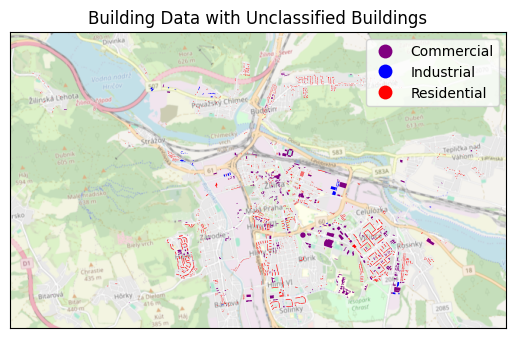

FOR NOW SUBSTITUTE COMMERCIAL FOR UNDEFINED BUILDING CLASSES


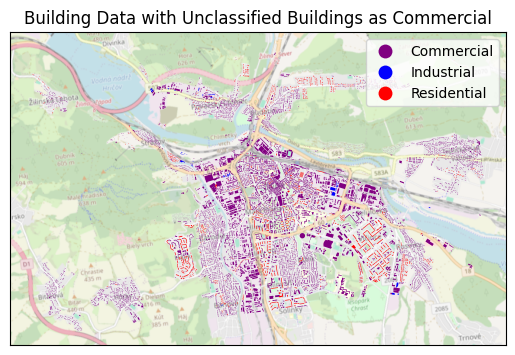

Done


In [9]:
# Shapefile name with reclassied buildings (output)
shpOSMreclass = os.path.join(dirOSM,'OSM_Building_Reclassified.shp')

# Building classification created earlier
bldgClasses = pd.read_csv(csvOSMclasses)

# Merge the spatial data with the new information
gdfOSMreclass = pd.merge(gdfOSM, bldgClasses, on='building', how='left')

# Plot without unclassified buildings
ax = gdfOSMreclass.plot(column='bldgClass', legend=True, cmap=cmap_cls)
ctx.add_basemap(ax, crs=gdfOSMreclass.crs, source=ctx.providers.OpenStreetMap.Mapnik,
                attribution='', alpha=0.7)
ax.set_xticks([]), ax.set_yticks([])
plt.title('Building Data with Unclassified Buildings')
plt.show()

# Substitute commercial for undefined (null) building classes
print('FOR NOW SUBSTITUTE COMMERCIAL FOR UNDEFINED BUILDING CLASSES')
gdfOSMreclass['bldgClass'] = gdfOSMreclass['bldgClass'].fillna('Commercial')

# Write classified structures to file
gdfOSMreclass.to_file(shpOSMreclass)


# Plot with unclassified buildings as commercial
ax = gdfOSMreclass.plot(column='bldgClass', legend=True, cmap=cmap_cls)
ctx.add_basemap(ax, crs=gdfOSMreclass.crs, source=ctx.providers.OpenStreetMap.Mapnik,
                attribution='', alpha=0.7)
ax.set_xticks([]), ax.set_yticks([])
plt.title('Building Data with Unclassified Buildings as Commercial')
plt.show()

print('Done')

## Flood Depths
Here the flood depth rasters for each event return period are loaded.
- The raster depths are then aggregated to each based on the desired statistic (mean, maximum or minimum depth or all three).
- For each return period a map of the flood raster is generated as well as a map with the flood depths in each building.

Computing Building Water Depths:  RP= 10
  Loading water depth for selected bounds:  RP= 10
  ./data/floodmap_EFAS_RP010_C.tif
Computing Building Water Depths:  RP= 20
  Loading water depth for selected bounds:  RP= 20
  ./data/floodmap_EFAS_RP020_C.tif
Computing Building Water Depths:  RP= 50
  Loading water depth for selected bounds:  RP= 50
  ./data/floodmap_EFAS_RP050_C.tif
Computing Building Water Depths:  RP= 100
  Loading water depth for selected bounds:  RP= 100
  ./data/floodmap_EFAS_RP100_C.tif


/opt/homebrew/anaconda3/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


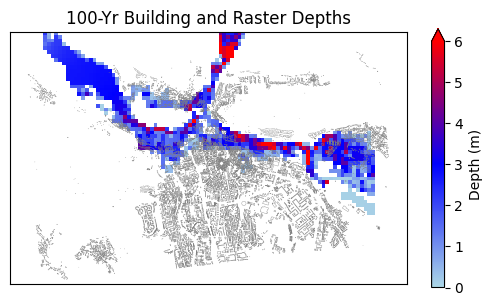

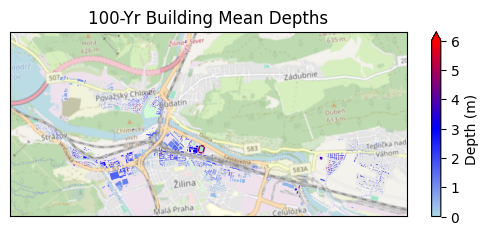

Computing Building Water Depths:  RP= 200
  Loading water depth for selected bounds:  RP= 200
  ./data/floodmap_EFAS_RP200_C.tif
Computing Building Water Depths:  RP= 500
  Loading water depth for selected bounds:  RP= 500
  ./data/floodmap_EFAS_RP500_C.tif
Done


In [10]:
for RP in ReturnPeriods:

    print("Computing Building Water Depths:  RP=", str(RP))
    print('  Loading water depth for selected bounds:  RP=', str(RP))

    strRP = f'{RP:03d}'
    rastDepths = f'floodmap_EFAS_RP{strRP}_C.tif'
    rastDepths = os.path.join(dirDepths, rastDepths)
    rastDepths_zoom = rastDepths.replace('.tif', '_zoom.tif')
    print(f'  {rastDepths}')

    # Keep only the building, bldgClass and geometry columns
    gdfDamage = gdfOSMreclass[['building', 'bldgClass', 'geometry']].copy()

    # Compute building areas in m2
    gdfDamage['Area_m2'] = gdfDamage.geometry.area

    # Read the raster using rasterio
    with rasterio.open(rastDepths) as src:
        window = from_bounds(xMin, yMin, xMax, yMax, src.transform)
        rDepths = src.read(1, window=window)
        rDepths = np.ma.masked_where((rDepths < -999) | (rDepths > 1000), rDepths)
        missing_data_value = src.nodata

        with rasterio.open(
            rastDepths_zoom,
            'w',
            driver='GTiff',
            height=rDepths.shape[0],
            width=rDepths.shape[1],
            count=1,
            dtype=rDepths.dtype,
            crs=src.crs,
            transform=src.window_transform(window),
            nodata=missing_data_value
        ) as dst:
            dst.write(rDepths, 1)

    # Perform zonal statistics directly on the raster array
    result = rasterstats.zonal_stats(
        gdfDamage,
        rDepths,
        nodata=src.nodata,
        affine=src.window_transform(window),
        stats=['mean', 'min', 'max'],
        all_touched=True
    )

    # Update geodataframe with zonal statistics
    gdfDamage["MeanDepth"] = [entry["mean"] for entry in result]
    # gdfDamage["MeanDepth"] = np.maximum(gdfDamage["MeanDepth"].fillna(0), 0.0)
    gdfDamage["MinDepth"] = [entry["min"] for entry in result]
    gdfDamage["MaxDepth"] = [entry["max"] for entry in result]

    if RP == 100:
        # Plot rasters
        fig, ax = plt.subplots()
        im = ax.imshow(rDepths, vmin=0, vmax=6, cmap=cmap_h2o, extent=(xMin, xMax, yMin, yMax))
        cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', label='Depth (m)',
                            shrink=0.7)
        gdfDamage.plot(ax=ax, edgecolor='grey', linewidth=0.25, facecolor='none')
        ax.set_xticks([]), ax.set_yticks([])
        plt.title(f'{RP}-Yr Building and Raster Depths')
        plt.show()

        # Map depths > 0 at building level
        gdf_filtered = gdfDamage[gdfDamage['MeanDepth'] > 0]
        fig, ax = plt.subplots()  # Adjust figsize as needed
        cax = gdf_filtered.plot(column='MeanDepth', vmin=0, vmax=6, cmap=cmap_h2o, ax=ax)
        cbar = fig.colorbar(cax.collections[0], extend='max', ax=ax, orientation='vertical',
                            shrink=0.5)
        cbar.set_label('Depth (m)')
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution='',
                        crs=gdfDamage.crs, alpha=0.8)
        ax.set_xticks([]), ax.set_yticks([])
        plt.title(f'{RP}-Yr Building Mean Depths')
        plt.show()

        # Save the updated geodataframe to a shapefile
        shpDepths = os.path.join(dirResults, f'Depths_Building_RP{RP}.shp')
        gdfDamage.to_file(shpDepths, driver='ESRI Shapefile')

print('Done')

### Building Damage
Based on the flood water depth, the damage to the building (reconstruction costs) and its contents are determined.
- First the fractional building damage is calculated applying the JRC damage functions for each classifiction (residential, commerical, etc).
- Then the fractional damage is multiplied times the maximum damage value per square meter and the building footprint area in meters and written to a shapefile.
- The damages in millions of Euros summed over all of the classes are mapped for each return period level.

Computing Building Damage:  RP=10
Damage for Mean depth
Computing Building Damage:  RP=20
Damage for Mean depth
Computing Building Damage:  RP=50
Damage for Mean depth
Computing Building Damage:  RP=100
Damage for Mean depth


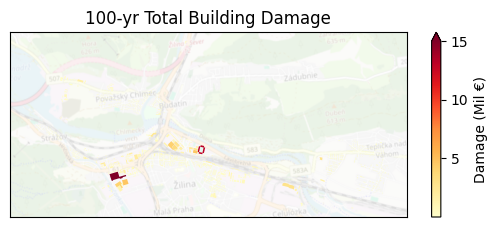

Computing Building Damage:  RP=200
Damage for Mean depth
Computing Building Damage:  RP=500
Damage for Mean depth
Done computing damage for each building


In [11]:
for RP in ReturnPeriods:

    print(f'Computing Building Damage:  RP={str(RP)}')

    # Read Building Water Depth Shapefile
    shpDepths = os.path.join(dirResults, f'Depths_Building_RP{str(RP)}.shp')
    gdfDamage = gpd.read_file(shpDepths)

    for Depth in Depths:

        if Depth == 'Mean':
            depthStat = 'mean'
        elif Depth == 'Maximum':
            depthStat = 'max'
        elif Depth == 'Minimum':
            depthStat = 'min'
        else:
            print('Depth statistic does not exist.')
            print('  Current options are Mean, Minimum, and Maximum')
            sys.exit()

        print(f'Damage for {Depth} depth')

        statName = depthStat.title() + 'Depth'

        # Compute the damage factor for each building class

        gdfDamage['TotDamage'] = 0  # Initialize TotalDamage column

        for dmgClass in DamageClasses:

            bldgDamage = 'fTRS'+depthStat if dmgClass == 'Transportation' \
                else 'f'+dmgClass[:3].upper()+depthStat
            dmgName = 'Dmg'+bldgDamage[1:]

            # Damage factors and maximum damage value including contents
            if dmgClass == 'Residential':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_RES)
                MaxDmg = MaxDmgRES.sum()
            elif dmgClass == 'Commercial':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_COM)
                MaxDmg = MaxDmgCOM.sum()
            elif dmgClass == 'Industrial':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_IND)
                MaxDmg = MaxDmgIND.sum()
            elif dmgClass == 'Transportation':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_TRS)
                MaxDmg = MaxDmgTRS.sum()
            elif dmgClass == 'Agriculture':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_AGR)
                MaxDmg = MaxDmgAGR.sum()
            else:
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_GEN)
                MaxDmg = (MaxDmgRES.sum() + MaxDmgCOM.sum() + MaxDmgIND.sum()) / 3

            # Damage computation
            gdfDamage.loc[gdfDamage['bldgClass'] != dmgClass, bldgDamage] = 0
            gdfDamage[dmgName] = gdfDamage[bldgDamage] * gdfDamage['Area_m2'] * MaxDmg

            # Add TotalDamage in millions of €
            gdfDamage['TotDamage'] += gdfDamage[dmgName] / 10**6

        gdfDamage.to_file(shpDepths, driver='ESRI Shapefile')

        # Plotting the GeoDataFrame with filtered values
        if RP == 100:
            fig, ax = plt.subplots()  # Adjust figsize as needed
            cax = gdfDamage.plot(column='TotDamage', cmap='YlOrRd', ax=ax)
            cbar = fig.colorbar(cax.collections[0], extend='max', ax=ax, orientation='vertical',
                                shrink=0.5)
            cbar.set_label('Damage (Mil €)')
            ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution='',
                crs=gdfDamage.crs, alpha=0.25)
            ax.set_xticks([]), ax.set_yticks([])
            plt.title(f'{str(RP)}-yr Total Building Damage')
            plt.show()


print('Done computing damage for each building')

### Total Damage
The total damage for the region of interest is summed, written to a CSV file, and mapped.

In [12]:
nDmg = np.append(DamageClasses, 'Total')

dfDMGs = pd.DataFrame(columns=[])
dfDMGs.index = nDmg
dfDMGs.index.name = 'Building Class'

for Depth in Depths:

    if Depth not in ['Mean', 'Maximum', 'Minimum']:
        print('Depth statistic does not exist.')
        print('  Current options are Mean, Minimum, and Maximum')
        sys.exit()

    print(f'Damage for {Depth} depth')

    for RP in ReturnPeriods:

        shpOSM = os.path.join(dirResults, f'Depths_Building_RP{RP}.shp')
        gdfOSM = gpd.read_file(shpOSM)

        vDmg = pd.DataFrame(columns=[])
        for dmgClass in DamageClasses:
            dmgName = f'DmgTRS{Depth.lower()}' if dmgClass == 'Transportation' else \
            f'Dmg{dmgClass[:3].upper()}{Depth.lower()}'
            vDmg = np.append(vDmg, gdfOSM[dmgName].sum())

        totDmg = sum(vDmg)
        vDmg = np.append(vDmg, totDmg)
        totDmg_byclass = pd.DataFrame(vDmg + [sum(vDmg)])
        # Assign names to the dataframe headers
        totDmg_byclass.columns = [f'{RP}-yr']
        totDmg_byclass.index = [nDmg]

        # Compute the total damage across the entire area of interest
        print(f'  RP={RP}: Total damage (mil €) = {round(totDmg/10**6, 2)}')

        dfDMGs[f'{RP}-yr'] = np.array(totDmg_byclass)

    damage_csv_filename = os.path.join(dirResults, f'DamageTotal_{Depth}.csv')
    dfDMGs.to_csv(damage_csv_filename)

print('Done')

Damage for Mean depth
  RP=10: Total damage (mil €) = 201.34
  RP=20: Total damage (mil €) = 232.88
  RP=50: Total damage (mil €) = 272.13
  RP=100: Total damage (mil €) = 305.34
  RP=200: Total damage (mil €) = 335.64
  RP=500: Total damage (mil €) = 370.27
Done


### Expected Annual Damage
Integrating the damage vs exceedance probability (inverse return period) curve is integrated to provide an estimate of the expected annual damage (EAD) in millions of Euros.  The is the damage that the region would expect on average in any given year.

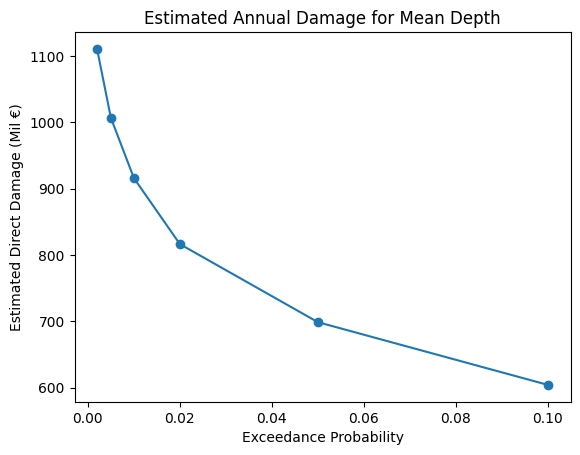

Total Expected Annual Damage for Mean depth in Mil €: 71.94
Done


In [13]:
for Depth in Depths:

    if Depth == 'Mean':
        depthStat = 'mean'
    elif Depth == 'Maximum':
        depthStat = 'max'
    elif Depth == 'Minimum':
        depthStat = 'min'
    else:
        print('Depth statistic does not exist.')
        print('  Current options are Mean, Minimum, and Maximum')
        sys.exit()

    # Load damage data for the current depth statistic
    damage_csv_filename = os.path.join(dirResults, f'DamageTotal_{depthStat}.csv')
    dfDMGs = pd.read_csv(damage_csv_filename, index_col=0)

    # Plot estimated direct damage vs exceedance probability
    totDmg = dfDMGs.loc['Total'] / 10**6
    probRPs = 1 / np.array(ReturnPeriods)
    plt.plot(probRPs, totDmg, marker='o', linestyle='-')
    plt.xlabel('Exceedance Probability')
    plt.ylabel('Estimated Direct Damage (Mil €)')
    plt.title(f'Estimated Annual Damage for {Depth} Depth')
    plt.show()

    # Compute the total Estimated Annual Damage (EAD) over all return periods
    iTot = dfDMGs.index.get_loc('Total')
    EAD = 0
    for iRP in range(len(ReturnPeriods)-1):
        diffRP = probRPs[iRP] - probRPs[iRP+1]
        avgDMG = (dfDMGs.iloc[iTot, iRP+1] + dfDMGs.iloc[iTot, iRP]) / 2
        EAD = EAD + avgDMG * diffRP

    print(f'Total Expected Annual Damage for {Depth} depth in Mil €: {round(EAD/10**6, 2)}')


print('Done')